# Praca domowa z ML numer 6

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Tree_Methods/homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Oznaczenia:
$R_m(X_j, t)$ <- region powstały po podzieleniu aktualnego liścia względem cechy $X_j$ przy poziomie $t$ (nowe liście)\
$\bar{y}_{R_m}$ <- średnia wartość zmiennej wynikowej w regionie $R_m$\
$T$ <- aktualne drzewo\
$T(X_j, t)$ <- drzewo, które powstało z T po dodaniu dwóch nowych liści $R_1(X_j, t)$, $R_2(X_j, t)$\
$\mathrm{Leaves}(T(X_j, t))$ <- zbiór wszystkich możliwych liści w drzewie $T(X_j, t)$

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Słowem wstępu...

Celem tej pracy domowej jest opisanie wybranych podejść do wyznaczania cech i ich poziomów rozdzielenia przy budowaniu drzewa decyzyjnego. Będziemy chcieli sprawdzić trzy metody:

1. **Lokalna minimalizacja**  
   błędu średniokwadratowego dla różnych wartości $t$ oraz różnych cech $X_j$. Innymi słowy, w kolejnych krokach budowania drzewa będziemy chcieli znaleźć taką parę $(X_j^*, t^*)$, aby przy podziale kolejnych liści zachodziło
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$
   Takie podejście stosujemy dla każdego kolejnego liścia, co oznacza, że (jak sama nazwa wskazuje) jest to metoda lokalna – w danym momencie analizujemy tylko jednego rodzica i dwa nowe liście.

2. **Maksymalizacja przyrostu**  
   błędu średniokwadratowego również stanowi metodę lokalną, której idea polega na wybraniu pary $(X_j^*, t^*)$ tak, aby zmaksymalizować redukcję błędu po dodaniu nowych liści. Innymi słowy, wyznaczamy
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2}_{\text{Błąd średniokwadratowy u rodzica}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Błąd średniokwadratowy w nowych liściach}}
   \Bigr\}
   $$
   po dodaniu do aktualnego liścia dwóch nowych.

3. **Minimalizacja całości**  
   błędu średniokwadratowego. Jest to podejście bardziej złożone i – w przeciwieństwie do dwóch poprzednich – **nie jest metodą lokalną w sensie ścisłym** (choć w pewnym ograniczonym sensie można ją tak traktować). W danym momencie patrzymy na jeden wybrany liść drzewa $T$ i dzielimy go na dwa regiony $R_1(X_j, t)$ oraz $R_2(X_j, t)$. Następnie analizujemy, jak wygląda błąd średniokwadratowy w całym drzewie $T(X_j, t)$, ale w podziale na poszczególne regiony. Innymi słowy, szukamy
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2.
   $$
   Jest to poprawnie zdefiniowane zadanie, ponieważ wszystkie możliwe liście (regiony) $R_m$ stanowią rozbicie przestrzeni wejściowej na rozłączne obszary.




# Równoważność poszczególnych podejść

Można się zastanowić, czy pomiędzy powyższymi podejściami istnieją równoważności. Innymi słowy: czy różne metody prowadzą do tych samych wyników? W szczególności – zgodnie z treścią zadania – przyjrzymy się, czy **metoda 1** prowadzi do takich samych wyników, co **metoda 2**.

Wystarczy zestawić matematyczne formuły. W metodzie 1 jesteśmy w danym liściu, dzielimy go na dwa względem cech i progów, i szukamy pary $(X_j, t)$, która minimalizuje błąd średniokwadratowy:

$$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
$$

Korzystając z poniższych przekształceń (pierwsza suma jest stała z perspektywy aktualnie dzielonego liścia), mamy:

\begin{align*}
\max_{X_j, t} \Bigl\{
   \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\;
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\} &= \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;+\ \max_{X_j, t} \Bigl\{ -
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\}\\
    &= \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\ \min_{X_j, t} \Bigl\{
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\}.
\end{align*}

Wobec tego:

$$
\arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 = \arg\max_{X_j, t} \Bigl\{
   \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\;
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2
   \Bigr\},
$$

czyli **podejście 1 jest równoważne podejściu 2**.


# Kod

W tej części pracy skupimy się na przeprowadzeniu doświadczenia. Wygenereujemy zbiór danych a następnie ręcznie zastosujemy wszystkie trzy powyższe metody, aby określić która jest domyślnie wbudowana we wcześniej wspomniany pakiet.

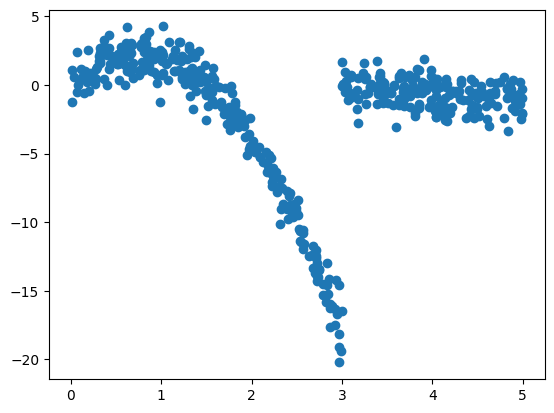

In [42]:
np.random.seed(439669)
N = 500 #<- ilość obserwacji w zbiorze danych
X = np.random.uniform(0,5, size = N)

noise = np.random.normal(0, 1, size = N)

#zbiór wybrany raczej for fun w taki sposób
Y = np.array([np.sin(el) if el > 3 else (6 * el - 4 * el**2) for el in x] + noise)

plt.scatter(X, Y)
plt.show()

W pierwszych wersjach pracy domowej udało mi się skonstruować funckję do szacowania dzrzewa dowolenej głędbokości. Funkcja jest dokładna i w przyszłości może się przydać do konstruowania innych drzew.

## Minimalizacja RSS lokalnie (I metoda)

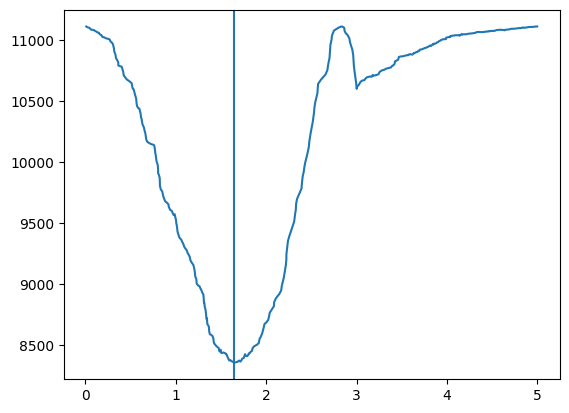

In [43]:
def RSS(y):
    if y.size == 0:
        return 0
    
    mean = np.mean(y)
    return np.sum((y - mean)**2)

# mamy tylko jedną cechę, więc nie ma tutaj probelmu

#bierzemy unikalne podziały
unique_values = np.sort(np.unique(X))
thresholds = (unique_values[1:] + unique_values[:-1])/2
all_rss = []
best_rss = np.inf
for t in thresholds:
    mask = X <= t

    left_rss = RSS(Y[mask])
    right_rss = RSS(Y[~mask])

    total_rss = right_rss + left_rss
    all_rss.append(total_rss)

    if total_rss < best_rss:
        best_rss = total_rss
        best_threshold = t

plt.plot(thresholds, all_rss)
plt.axvline(best_threshold)

A teraz zrobimy to samo, ale dla drzewa o max depth wynoszącym 2. W poprzednim przypadku wyznaczyliśmy już optymalny poziom. Przejdźmy dalej.

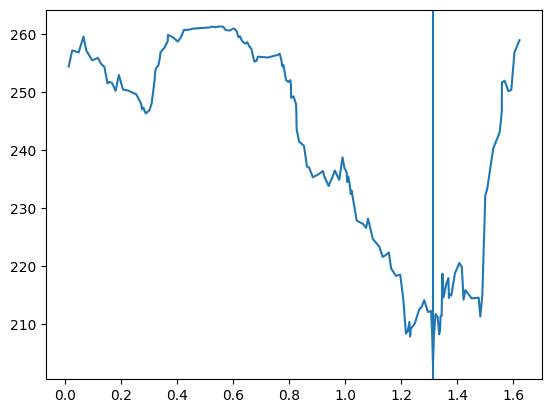

In [44]:
best_mask = X <= best_threshold
left_X = X[best_mask]
left_Y = Y[best_mask]


#przeprowadzamy procedurę raz zamieniąć X na left_X
unique_values_left = np.sort(np.unique(left_X))
thresholds_left = (unique_values_left[1:] + unique_values_left[:-1])/2
all_rss_left = []
best_rss = np.inf
for t in thresholds_left:
    mask = left_X <= t

    left_rss = RSS(left_Y[mask])
    right_rss = RSS(left_Y[~mask])

    total_rss = right_rss + left_rss
    all_rss_left.append(total_rss)

    if total_rss < best_rss:
        best_rss = total_rss
        best_threshold_left = t

plt.plot(thresholds_left, all_rss_left)
plt.axvline(best_threshold_left)

## Makysmalizacja przyrostu RSS (metoda II)

Metoda jest analogiczna jak wcześniejsza. Ponadto, przeszliśmy również przez dowód matematyczny, który pokazał, że metoda I i II są równoważne.

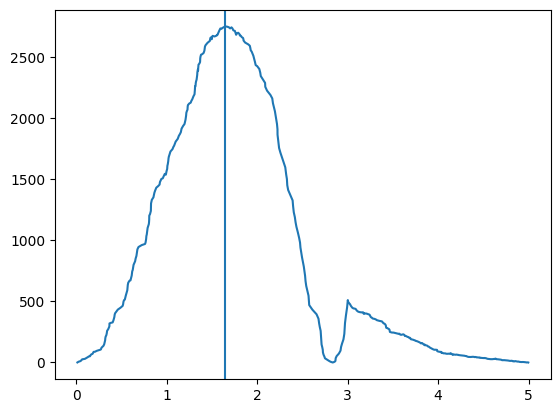

In [45]:
def RSS(y):
    if y.size == 0:
        return 0
    
    mean = np.mean(y)
    return np.sum((y - mean)**2)

# mamy tylko jedną cechę, więc nie ma tutaj probelmu

#bierzemy unikalne podziały
unique_values = np.sort(np.unique(X))
thresholds = (unique_values[1:] + unique_values[:-1])/2
gain_rss_all = []
best_rss_gain = -np.inf
for t in thresholds:
    mask = X <= t
    parent_RSS = RSS(Y)
    left_rss = RSS(Y[mask])
    right_rss = RSS(Y[~mask])

    total_rss = right_rss + left_rss
    gain_rss = parent_RSS - total_rss
    gain_rss_all.append(gain_rss)

    if gain_rss > best_rss_gain:
        best_rss_gain = gain_rss
        best_threshold = t

plt.plot(thresholds, gain_rss_all)
plt.axvline(best_threshold)

Jak wcześniej zrobimy to samo, ale dla drzewa głębokości 2.

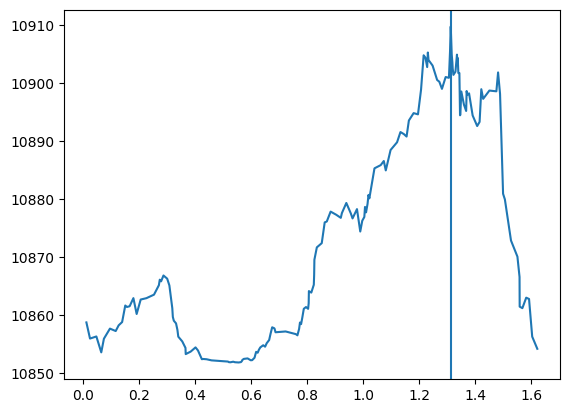

In [46]:
best_mask = X <= best_threshold
left_X = X[best_mask]
left_Y = Y[best_mask]

#bierzemy unikalne podziały
unique_values = np.sort(np.unique(left_X))
thresholds = (unique_values[1:] + unique_values[:-1])/2
gain_rss_all = []
best_rss_gain = -np.inf
for t in thresholds:
    mask = left_X <= t
    parent_RSS = RSS(Y)
    left_rss = RSS(left_Y[mask])
    right_rss = RSS(left_Y[~mask])

    total_rss = right_rss + left_rss
    gain_rss = parent_RSS - total_rss
    gain_rss_all.append(gain_rss)

    if gain_rss > best_rss_gain:
        best_rss_gain = gain_rss
        best_threshold = t

plt.plot(thresholds, gain_rss_all)
plt.axvline(best_threshold)

## Minimalizacja całkowitego RSS - na calym drzewie (metoda III)

Na początek zauważmy, że dla drzewa głębokości 1 (czyli zaczynamy od korzenia), minimlaizacja całkowitego RRS na drzewie jest równoznacza I metodzie. Przypominjmy jej wynik.

In [ ]:
#bierzemy unikalne podziały
unique_values = np.sort(np.unique(X))
thresholds = (unique_values[1:] + unique_values[:-1])/2
all_rss = []
best_rss = np.inf
for t in thresholds:
    mask = X <= t

    left_rss = RSS(Y[mask])
    right_rss = RSS(Y[~mask])

    total_rss = right_rss + left_rss
    all_rss.append(total_rss)

    if total_rss < best_rss:
        best_rss = total_rss
        best_threshold = t

plt.plot(thresholds, all_rss)
plt.axvline(best_threshold)

Rozpatrzymy teraz nowo powstałe podziały.


In [ ]:
best_mask = X <= best_threshold

right_X = X[~mask]
left_X = X[mask]
right_Y = Y[~mask]
left_Y = Y[mask]

